In [155]:
import gdown
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
import numpy as np
import scanpy as sc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from anndata.experimental.pytorch import AnnLoader

In [156]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, out_dim):
        super().__init__()

        modules = []
        for in_size, out_size in zip([input_dim]+hidden_dims, hidden_dims):
            modules.append(nn.Linear(in_size, out_size))
            modules.append(nn.LayerNorm(out_size))
            modules.append(nn.ReLU())
            modules.append(nn.Dropout(p=0.05))
        modules.append(nn.Linear(hidden_dims[-1], out_dim))
        self.fc = nn.Sequential(*modules)

    def forward(self, *inputs):
        input_cat = torch.cat(inputs, dim=-1)
        return self.fc(input_cat)

In [157]:
class CVAE(nn.Module):
    # The code is based on the scarches trVAE model
    # https://github.com/theislab/scarches/blob/v0.3.5/scarches/models/trvae/trvae.py
    # and on the pyro.ai Variational Autoencoders tutorial
    # http://pyro.ai/examples/vae.html
    def __init__(self, input_dim, n_conds, n_classes, hidden_dims, latent_dim):
        super().__init__()

        self.encoder = MLP(input_dim+n_conds, hidden_dims, 2*latent_dim) # output - mean and logvar of z

        self.decoder = MLP(latent_dim+n_conds, hidden_dims[::-1], input_dim)
        self.theta = nn.Linear(n_conds, input_dim, bias=False)

        self.classifier = nn.Linear(latent_dim, n_classes)

        self.latent_dim = latent_dim

    def model(self, x, batches, classes, size_factors):
        pyro.module("cvae", self)

        batch_size = x.shape[0]

        with pyro.plate("data", batch_size):
            z_loc = x.new_zeros((batch_size, self.latent_dim))
            z_scale = x.new_ones((batch_size, self.latent_dim))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            classes_probs = self.classifier(z).softmax(dim=-1)
            pyro.sample("class", dist.Categorical(probs=classes_probs), obs=classes)

            dec_mu = self.decoder(z, batches).softmax(dim=-1) * size_factors[:, None]
            dec_theta = torch.exp(self.theta(batches))

            logits = (dec_mu + 1e-6).log() - (dec_theta + 1e-6).log()

            pyro.sample("obs", dist.NegativeBinomial(total_count=dec_theta, logits=logits).to_event(1), obs=x.int())

    def guide(self, x, batches, classes, size_factors):
        batch_size = x.shape[0]

        with pyro.plate("data", batch_size):
            z_loc_scale = self.encoder(x, batches)

            z_mu = z_loc_scale[:, :self.latent_dim]
            z_var = torch.sqrt(torch.exp(z_loc_scale[:, self.latent_dim:]) + 1e-4)

            pyro.sample("latent", dist.Normal(z_mu, z_var).to_event(1))

In [158]:
adata = sc.read('cortex.h5ad')

In [159]:
sc.pp.filter_genes(adata, min_cells=1000)
adata

AnnData object with n_obs × n_vars = 3005 × 4608
    obs: 'cell_ids', 'label', 'label2'
    var: 'genes', 'n_cells'

In [160]:
adata.obs

,cell_ids,label,label2
0,1772071015_C02,interneurons,Int10
1,1772071017_G12,interneurons,Int10
2,1772071017_A05,interneurons,Int6
3,1772071014_B06,interneurons,Int10
4,1772067065_H06,interneurons,Int9
...,...,...,...
3000,1772067059_B04,endothelial-mural,Peric
3001,1772066097_D04,endothelial-mural,Vsmc
3002,1772063068_D01,endothelial-mural,Vsmc
3003,1772066098_A12,endothelial-mural,Vsmc


In [193]:
adata.var

,genes,n_cells
2,Fnbp1l,1167
17,Atp1b2,1341
24,Sub1,2872
30,Ptprf,1529
31,Cers5,1262
...,...,...
19928,Cdkl5,1065
19934,Rbbp7,1794
19946,Trappc2,1663
19947,Rab9,1708


In [161]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


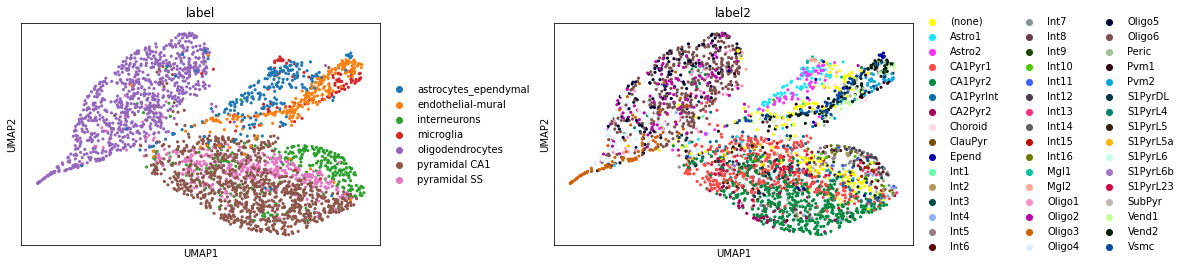

In [162]:
sc.pl.umap(adata, color=['label', 'label2'], wspace=0.35)

In [163]:
adata.X 

array([[ 3.,  9., 28., ...,  1.,  7.,  5.],
       [ 1.,  5., 41., ...,  1.,  1.,  0.],
       [ 6.,  8., 57., ...,  2.,  1.,  3.],
       ...,
       [ 0.,  0.,  1., ...,  0.,  2.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  2.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [164]:
adata.X.shape

(3005, 4608)

In [165]:
adata.obs['size_factors'] = adata.X.sum(1)
adata.obs['size_factors'] 

0       16811.0
1       17282.0
2       25263.0
3       25988.0
4       17316.0
         ...   
3000     3203.0
3001     1757.0
3002     3111.0
3003     2122.0
3004     3078.0
Name: size_factors, Length: 3005, dtype: float32

In [166]:
adata.obs['label'].cat.categories

Index(['astrocytes_ependymal', 'endothelial-mural', 'interneurons',
       'microglia', 'oligodendrocytes', 'pyramidal CA1', 'pyramidal SS'],
      dtype='object')

In [167]:
encoder_study = OneHotEncoder(sparse=False, dtype=np.float32)
encoder_study.fit(adata.obs['label'].to_numpy()[:, None])

OneHotEncoder(dtype=<class 'numpy.float32'>, sparse=False)

In [168]:
adata.obs['label2'].cat.categories

Index(['(none)', 'Astro1', 'Astro2', 'CA1Pyr1', 'CA1Pyr2', 'CA1PyrInt',
       'CA2Pyr2', 'Choroid', 'ClauPyr', 'Epend', 'Int1', 'Int2', 'Int3',
       'Int4', 'Int5', 'Int6', 'Int7', 'Int8', 'Int9', 'Int10', 'Int11',
       'Int12', 'Int13', 'Int14', 'Int15', 'Int16', 'Mgl1', 'Mgl2', 'Oligo1',
       'Oligo2', 'Oligo3', 'Oligo4', 'Oligo5', 'Oligo6', 'Peric', 'Pvm1',
       'Pvm2', 'S1PyrDL', 'S1PyrL4', 'S1PyrL5', 'S1PyrL5a', 'S1PyrL6',
       'S1PyrL6b', 'S1PyrL23', 'SubPyr', 'Vend1', 'Vend2', 'Vsmc'],
      dtype='object')

In [169]:
encoder_celltype = LabelEncoder()
encoder_celltype.fit(adata.obs['label2'])

LabelEncoder()

In [170]:
use_cuda = torch.cuda.is_available()

In [171]:
encoders = {
    'obs': {
        'label': lambda s: encoder_study.transform(s.to_numpy()[:, None]),
        'label2': encoder_celltype.transform
    }
}

In [172]:
dataloader = AnnLoader(adata, batch_size=128, shuffle=True, convert=encoders, use_cuda=use_cuda)

In [173]:
dataloader.dataset

AnnCollection object with n_obs × n_vars = 3005 × 4608
  constructed from 1 AnnData objects
    view of obsm: 'X_pca', 'X_umap'
    obs: 'cell_ids', 'label', 'label2', 'size_factors'

In [174]:
data_1=dataloader.dataset[:10]

In [175]:
data_1

AnnCollectionView object with n_obs × n_vars = 10 × 4608
    obsm: 'X_pca', 'X_umap'
    obs: 'cell_ids', 'label', 'label2', 'size_factors'

In [176]:
batch = dataloader.dataset[:10]

print('X:', batch.X.device, batch.X.dtype)
print('X_pca:', batch.obsm['X_pca'].device, batch.obsm['X_pca'].dtype)
print('X_umap:', batch.obsm['X_umap'].device, batch.obsm['X_umap'].dtype)
# and here you can see that the converters are applied to 'study' and 'cell_type'.
print('label:', batch.obs['label'].device, batch.obs['label'].dtype)
print('label2:', batch.obs['label2'].device, batch.obs['label2'].dtype)

X: cpu torch.float32
X_pca: cpu torch.float32
X_umap: cpu torch.float32
label: cpu torch.float32
label2: cpu torch.int32


In [177]:
n_conds = len(adata.obs['label'].cat.categories)
n_classes = len(adata.obs['label2'].cat.categories)
cvae = CVAE(adata.n_vars, n_conds=n_conds, n_classes=n_classes, hidden_dims=[128, 128], latent_dim=10)

if use_cuda:
    cvae.cuda()

In [178]:
optimizer = pyro.optim.Adam({"lr": 1e-3})
svi = pyro.infer.SVI(cvae.model, cvae.guide, optimizer, loss=pyro.infer.TraceMeanField_ELBO())

In [179]:
def train(svi, train_loader):
    epoch_loss = 0.
    for batch in train_loader:
        epoch_loss += svi.step(batch.X, batch.obs['label'], batch.obs['label2'], batch.obs['size_factors'])

    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [180]:
NUM_EPOCHS = 12

for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, dataloader)
    if epoch % 1 == 0 or epoch == NUM_EPOCHS-1:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

[epoch 000]  average training loss: 9271.1132
[epoch 001]  average training loss: 9270.1382
[epoch 002]  average training loss: 9271.6298
[epoch 003]  average training loss: 9272.2163
[epoch 004]  average training loss: 9273.4861
[epoch 005]  average training loss: 9275.6347
[epoch 006]  average training loss: 9269.2986
[epoch 007]  average training loss: 9276.2569
[epoch 008]  average training loss: 9270.2656
[epoch 009]  average training loss: 9271.4369
[epoch 010]  average training loss: 9270.3879
[epoch 011]  average training loss: 9272.5368


In [183]:
full_data = dataloader.dataset[:] # No copies yet, nothing is copied until you access specific attributes (.X, .obsm etc.).

In [185]:
means = cvae.encoder(full_data.X, full_data.obs['label'])[:, :10] # get mean values of the latent variables

In [186]:
adata.obsm['X_cvae'] = means.data.cpu().numpy()

In [187]:
sc.pp.neighbors(adata, use_rep='X_cvae')
sc.tl.umap(adata)

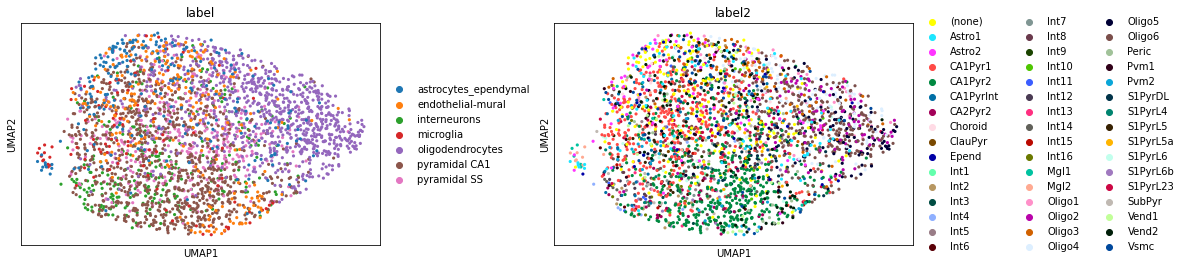

In [189]:
sc.pl.umap(adata, color=['label', 'label2'], wspace=0.35)

In [191]:
accuracy = (cvae.classifier(means).argmax(dim=-1)==full_data.obs['label2']).sum().item()/adata.n_obs

In [192]:
accuracy

0.0259567387687188

In [ ]:
data=sc.read_h5ad("data.h5ad")
data

In [ ]:
data.var_names_make_unique

In [ ]:
sc.pp.neighbors(data)
sc.tl.umap(data)

In [ ]:
sc.pl.umap(data, color=['label', 'label2'], wspace=0.35)